# Classification of MNIST

MNIST is a dataset consisting of handwritten numbers 0-9 widely used as a benchmark in machine learning. While the dataset is very simple, it is still in seminal papers to demonstrate proof of concept (i.e. [Dynamic Routing](https://arxiv.org/pdf/1710.09829.pdf)). Below we load some sample digits for you.

Benchmark datasets are very useful, to note a couple other widely used benchmarks: [SVHN](http://ufldl.stanford.edu/housenumbers/) (Street View House Numbers), [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) (Like MNIST, but more fashion), [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html) (10 and 100 different objects), and [ImageNet](http://www.image-net.org/) (very large real world image dataset).

We load up a downsampled MNIST dataset below. MNIST is usually 28x28, we will work with 8x8 images.

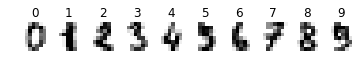

In [1]:
# Import datasets

%matplotlib inline

from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

digits = datasets.load_digits()
for index, (image, label) in enumerate(list(zip(digits.images, digits.target))[:10]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title('%i' % label)
plt.show()

# Part I

You will classifiy two numbers of your choice. Start by extracting two features from the image. We suggest looking at intensity and symmetry using `sklearn.model_selection.train_test_split`, a convenient function which will save 10% of the data for testing. We split the dataset into training and test sets. Save your test set so we can evaluate how well you classify.

`X_test` and `y_test` should be used to evaluate the performance of the classifier you build. Moving forward just work with `X_train` and `y_train`.

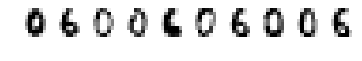

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np

number_a = 0 # TODO choose your digit
number_b = 6 # TODO choose your digit

digit_a_indexes = np.where(digits.target==number_a) 
digit_b_indexes = np.where(digits.target==number_b)
targets = np.concatenate((digits.target[digit_a_indexes], digits.target[digit_b_indexes]))
images = np.concatenate((digits.images[digit_a_indexes], digits.images[digit_b_indexes]))
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)
for index, image in enumerate(X_train[:10]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
plt.show()

# Feature Extraction

You will create 2 feature extractors based on the numbers you choose. These will be two functions which take in an image and output a single float. For example, image intensity and symmetry can be used as a features.

In [3]:
def compute_features(vector):
    image = vector.reshape(8, 8) # get back original image shape
    def compute_feature_a(image):
        '''compute_feature_a will compute intensity'''
        value = np.mean(image)
        return value

    def compute_feature_b(image):
        '''compute_feature_b will compute symmetry'''
        one_half = np.fliplr(image)
        sym = one_half*image
        sym = np.mean(sym)
        return sym
    
    return compute_feature_a(image), compute_feature_b(image)

Once you compute these two features, you can apply them to your images. Don't worry about the details of the first function below, all it does is map the `compute_features` function you wrote to each image in your `X_train` variable.

Afterwards let us plot the features you've crafted to see if they can separate into two classes.

(20.0625, 78.71875)

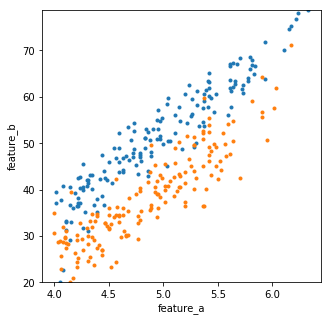

In [4]:
# Apply and plot your features

X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_features_test = np.apply_along_axis(compute_features, 1,
                                 X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

X_features_a = X_features[np.where(y_train==number_a)]
X_features_b = X_features[np.where(y_train==number_b)]

plt.figure(figsize=(5,5))
plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.')
plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.')
plt.xlabel('feature_a')
plt.ylabel('feature_b')
plt.ylim(X_features[:, 1].min(), X_features[:, 1].max()) 

# Linear Classification with Pseudo Inverse

`X_features` is a 2 dimensional array of features and `y_train` is our ground truth label. Find the best plane that separates these two classes using the pseudo inverse and plot it. For this problem, we need to set `y=-1` for `number_a` and `y=1` for `number_b`.

The loss $L$ we would like to minimize for each $i$ row in our matrix is.

$$L  = \frac{1}{2}\Sigma (y^{(i)} - W^{T}x^{(i)})^{2}$$

where

$$x^{(i)} = 
\begin{bmatrix}
    feature_a \\
    feature_b \\
\end{bmatrix}$$

$$W = 
\begin{bmatrix}
    w_1 \\
    w_2 \\
\end{bmatrix}$$


In matrix form we convert $x^{(i)}$ into $X$ which is the number of examples we have, in our case is MNIST digit features extracted.

$$X = 
\begin{bmatrix}
    feature_{a1} & feature_{b1} \\
    feature_{a2} & feature_{b2} \\
    ... & ... \\
    feature_{ai} & feature_{bi} \\
\end{bmatrix}$$


$$L  = \frac{1}{2}( Y-XW )^{T} (Y-XW)$$


### Explain

Let's solve L analytically, set $\frac{d}{dW}L = 0$ and solve. Show your steps.

Step 1: $$L  = \frac{1}{2}( Y-XW )^{T} (Y-XW)$$

Step 2: $$ \frac{d}{dW}L  = \frac{d}{dW} \frac{1}{2}( Y-XW )^{T} (Y-XW)$$

Step 3: $$ \frac{d}{dw}L = \frac{1}{2}[(Y^TY - 2W^TX^TY + W^TX^TXW]$$

Step 4: $$ \frac{d}{dw}L = \frac{1}{2}[0 - 2X^TY + 2X^TXW] = 0 $$

Step 5: $$ W = (X^TX)^{-1}X^TY $$

### Compute
Going back to linear algebra, we can re-write the classification problem as $Xw = y^*$, as we did during class. Here, $X$ is our features matrix `X_features` that has the features of each data example along each row, $y^*$ is our `pseudo_y` vector, and $w$ is the unknown weights vector that we'd like to figure out.

The pseudo inverse is $$(X^{T}X)^{-1}X^{T} = X^{+}$$

Solving for $w$, $$w = X^{+}y^*$$

To perform this computation: 

#### (a) create a features vector $X$ and compute its pseudo inverse. (This is the var `X_features`)

#### (b) create a vector like $y^*$ to hold the labels. (Done below for you as `pseudo_y`)

#### (c) find $w$

In [5]:
pseudo_y = np.copy(y_train)
pseudo_y[y_train == number_a] = -1
pseudo_y[y_train == number_b] = 1

py_test = np.copy(y_test)
py_test[y_test == number_a] = -1
py_test[y_test == number_b] = 1

# Calculate x below
# ...
X = np.linalg.pinv(X_features)
w = X@pseudo_y
w

array([ 0.74281133, -0.08024957])

### (d) To examine the result of the least squares solution under this formulation, compute the train and test error using an appropriate threshold. Does your trained model generalize well to the test data? 

Create a function called `accuracy_metrics` which does this.

In [6]:
def accuracy_metrics(features,label,weight):
    # features should be your X_features
    # label should be the y^{i} label
    predicted = features@weight
    predicted[np.where(predicted > 0)] = 1
    predicted[np.where(predicted <= 0)] = -1
    accuracy = len(predicted[(predicted==label)])/len(predicted)
    
    return accuracy*100 # Return the % accuracy
    

### (e) Write a function that visualizes the decision boundary corresponding to your chosen threshold (you can either draw a line or shade the region above/below the threshold). 

The function `visualize_model` should take in features, labels, and your calculated weights. It should show a matplotlib figure.

In [7]:
def newline(weight):
    if len(weight) == 2:
        p1 = weight[0]
        p2 = weight[1]
        ax = plt.gca()
        xmin, xmax = ax.get_xbound()
        if(p2 == 0):
            xmin = xmax = 0
            ymin, ymax = ax.get_ybound()
        else:
            ymax = -p1/p2*(xmax)
            ymin = -p1/p2*(xmin)
        l = mlines.Line2D([xmin,xmax], [ymin,ymax], color = "g", label = "Decision")
        ax.add_line(l)
        
    elif len(weight) == 3:
        p1 = weight[0]
        p2 = weight[1]
        b = weight[2]
        ax = plt.gca()
        xmin, xmax = ax.get_xbound()
        if(p2 == 0):
            xmin = xmax = b/p1
            ymin, ymax = ax.get_ybound()
        else:
            ymax = -p1/p2*(xmax) - b/p2
            ymin = -p1/p2*(xmin) - b/p2
        l = mlines.Line2D([xmin,xmax], [ymin,ymax], color = "g", label = "Decision")
        ax.add_line(l)
        
    return l

Above function from [here](https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib/36479941)

In [8]:
def visualize_model(features, labels, weights):
    plt.figure(figsize=(5,5))
    X_features_a = features[np.where(labels==-1)]
    X_features_b = features[np.where(labels==1)]
    plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.', label = "{}".format(number_a))
    plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.', label = "{}".format(number_b))
    plt.xlabel('feature_a')
    plt.ylabel('feature_b')
    plt.ylim(features[:, 1].min(), features[:, 1].max()) 
    newline(weights)
    plt.gca().legend(loc = 1)
    return None

Train Accuracy = 82.972136%
Test Accuracy = 80.555556%


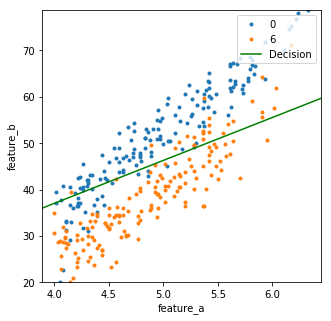

In [9]:
print("Train Accuracy = {:2f}%".format(accuracy_metrics(X_features, pseudo_y, w)))
print("Test Accuracy = {:2f}%".format(accuracy_metrics(X_features_test, py_test, w)))
visualize_model(X_features, pseudo_y, w)

### (f) Repeat the above steps after adding in a bias term, allowing for the classification line to not pass through the origin. You can do this by augmenting the X feature matrix with an additional feature column of ones, and making the unknown weight vector one entry longer -- does performance improve?

If you created your functions correctly, you shouldn't need to change them and you only need to modify `X_features`. 

Accuracy = 90.402477%
Test Accuracy = 80.555556%
Train Data
Test Data


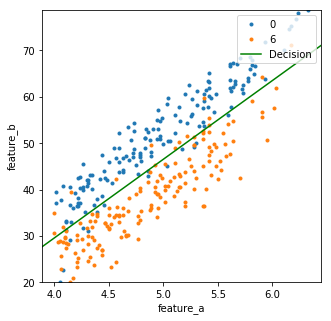

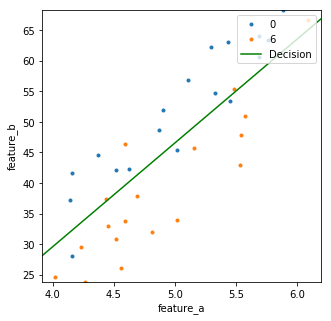

In [10]:
# Find w and bias

# Get the test and train accuracy of your model with bias

# Visualize the model, you may need to change your code.

X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_features_test = np.apply_along_axis(compute_features, 1,
                                 X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))


X_features_ones = np.append(X_features, np.ones((X_features.shape[0],1)), axis = 1)
X_features_test_ones = np.append(X_features_test, np.ones((X_features_test.shape[0],1)), axis = 1)
pseudo_y = np.copy(y_train)
pseudo_y[y_train == number_a] = -1
pseudo_y[y_train == number_b] = 1

py_test = np.copy(y_test)
py_test[y_test == number_a] = -1
py_test[y_test == number_b] = 1

# Calculate x below
# ...
X = np.linalg.pinv(X_features_ones)
w = X@pseudo_y

print("Accuracy = {:2f}%".format(accuracy_metrics(X_features_ones, pseudo_y,w)))
print("Test Accuracy = {:2f}%".format(accuracy_metrics(X_features_test_ones, py_test, w)))
print("Train Data")
visualize_model(X_features_ones, pseudo_y, w)
print("Test Data")
visualize_model(X_features_test_ones, py_test, w)



# Linear Classification with Finite Differences

Rather than use pseudo inverse (analytically solving your optimization equation). Instead, initialize your parameter x to some random numbers. Move x some small epsilon amount in the each direction to compute the total change in your loss and calculate the gradient. Then update x by taking a small step in that gradient direction. You can execute this in a for loop for a set number of iterations, or until the gradient reaches some threshold value of not changing very much.

1. Solve for x
2. Get training and test accuracy every $n$ steps
3. Plot the decision boundary every $n$ steps

### Define a loss.

In [11]:
def loss(features, labels, weights):
    return np.linalg.norm((labels - features@weights))

### Now iteratively solve for your weights w

In [12]:
def get_gradient(w, features, pseudo_labels, delta, loss_f):
    w_1 = np.copy(w)
    w_2 = np.copy(w)
    
    loss_o = loss_f(features, pseudo_labels, w)
    loss_new = [0,0]
    
    w_1[0] = w_1[0]+delta
    loss_new[0] = loss_f(features, pseudo_labels, w_1)
    
    w_2[1] = w_2[1]+delta
    loss_new[1] = loss_f(features, pseudo_labels, w_2)
    
    diff = (loss_new-loss_o)/delta
    
    return diff/np.linalg.norm(diff)

Accuracy = 50.464396%
Test Accuracy = 50.000000%
Accuracy = 50.464396%
Test Accuracy = 50.000000%
Accuracy = 53.869969%
Test Accuracy = 50.000000%


array([ 0.15556104, -0.01304796])

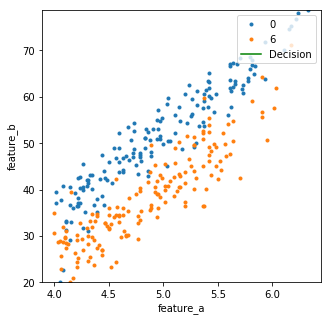

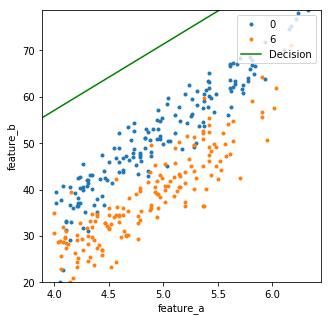

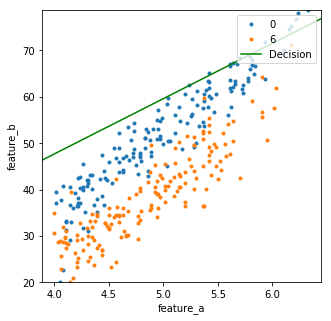

In [13]:
w = np.random.rand(2) # init weights to some random value.
num_iterations = 300 # set this to the number of iterations
delta = 1e-9 # This may need to be adjusted
step_size = 1e-2
step = 100
for i in range(num_iterations):
    # move x0 some delta and calculate derivative in x0 direction
    # move x1 some delta and calculate derivative in x1 direction
    # update x0 and x1 some step_size in the direction of steepest descent
    grad = get_gradient(w, X_features, pseudo_y, delta, loss)
    w = w + step_size*(-grad)
    if (i+1)%step == 0:
        print("Accuracy = {:2f}%".format(accuracy_metrics(X_features, pseudo_y, w)))
        print("Test Accuracy = {:2f}%".format(accuracy_metrics(X_features_test, py_test, w)))
        visualize_model(X_features, pseudo_y, w)
w

# Logistic Classification with Finite Differences

Now, let's consider the same problem with a different loss function.

$$L = \frac{1}{N}\sum_{i=1}^n ln(1 + e^{-y^{(i)}W^{T}x^{(i)}})$$

Use finite differences to compute the gradient and iteratively calculate $W$

1. Solve for x
2. Get training and test accuracy every $n$ steps
3. Plot the decision boundary every $n$ steps


In [14]:
logistic_y = np.copy(y_train)
logistic_y[y_train == number_a] = -1
logistic_y[y_train == number_b] = 1
ly_test = np.copy(y_test)
ly_test[y_test == number_a] = -1
ly_test[y_test == number_b] = 1

In [15]:
def logistic_loss(features, labels, weights):
    predicted = features@weights
    loss = np.exp(-1*np.multiply(labels, predicted))
    loss = 1 + loss
    loss = np.log(loss)
    loss = np.mean(loss)
    return loss

Accuracy = 83.591331%
Test Accuracy = 83.333333%
Accuracy = 82.662539%
Test Accuracy = 77.777778%
Accuracy = 82.352941%
Test Accuracy = 77.777778%
Accuracy = 82.352941%
Test Accuracy = 77.777778%
Accuracy = 82.662539%
Test Accuracy = 77.777778%


array([ 0.7197506 , -0.07629333])

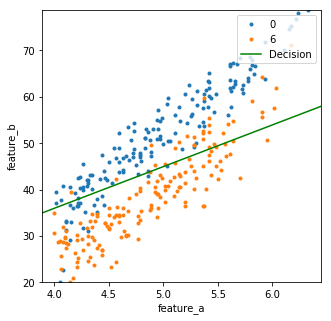

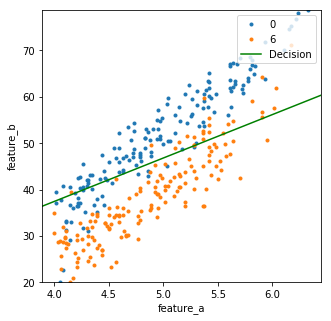

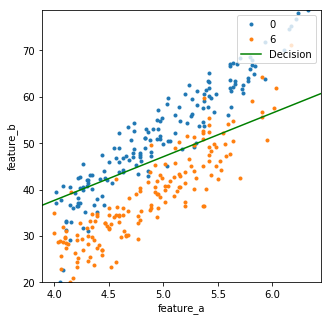

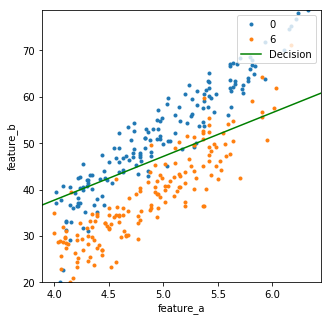

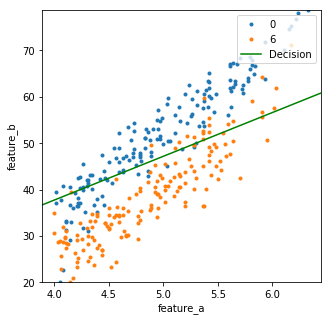

In [16]:
w = np.random.rand(2) # init weights to some random value.
num_iterations = 500 # set this to the number of iterations
delta = 1e-9 # This may need to be adjusted
step_size = 1e-2
step = 100
for i in range(num_iterations):
    # move x0 some delta and calculate derivative in x0 direction
    # move x1 some delta and calculate derivative in x1 direction
    # update x0 and x1 some step_size in the direction of steepest descent
    grad = get_gradient(w, X_features, logistic_y, delta, logistic_loss)
    w = w + step_size*(-grad)
    if (i+1)%step == 0:
        print("Accuracy = {:2f}%".format(accuracy_metrics(X_features, logistic_y, w)))
        print("Test Accuracy = {:2f}%".format(accuracy_metrics(X_features_test, ly_test, w)))
        visualize_model(X_features, logistic_y, w)
w

# Part II

Now let’s repeat the exercise above, but using a different set of features. Here, let’s assume that we have a camera that has just two pixels in it, which is taking pictures of the MNIST image dataset. One of these two pixels will detect the total intensity from the top half of each digit to form feature x_1, and the other pixel will detect the total intensity from the bottom half of each digit to form feature x_2. Please use these two top/bottom total intensities to form a new feature vector for each MNIST image that you’re using for classification, and repeat the exercise above to obtain a plot of classification performance and an average classification accuracy score. 

**Note that this classification score (in some sense) reflects what would be possible with a "normal" camera.**

 - Plot Points after feature generation
 - Linear Classification (Pseudo or Gradient method)
   - test/train accuracy
 - Logistic Classification
   - test/train accuracy

In [17]:
def compute_features(vector):
    image = vector.reshape(8, 8) # get back original image shape
    def compute_feature_a(image):
        '''compute_feature_a will compute ...'''
        value = np.mean(image[0:int(image.shape[0]/2),:])
        return value

    def compute_feature_b(image):
        '''compute_feature_b will compute ...'''
        value = np.mean(image[int(image.shape[0]/2):,:])
        return value
    
    return compute_feature_a(image), compute_feature_b(image)

Train Accuracy = 97.213622%
Test Accuracy = 100.000000%


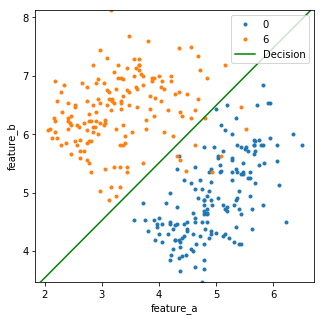

In [18]:
X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_features_test = np.apply_along_axis(compute_features, 1,
                                 X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

X_features_a = X_features[np.where(y_train==number_a)]
X_features_b = X_features[np.where(y_train==number_b)]

X_features_ones = np.append(X_features, np.ones((X_features.shape[0],1)), axis = 1)
X_features_test_ones = np.append(X_features_test, np.ones((X_features_test.shape[0],1)), axis = 1)

pseudo_y = np.copy(y_train)
pseudo_y[y_train == number_a] = -1
pseudo_y[y_train == number_b] = 1

py_test = np.copy(y_test)
py_test[y_test == number_a] = -1
py_test[y_test == number_b] = 1

# Calculate x below
# ...
X = np.linalg.pinv(X_features_ones)
w = X@pseudo_y

print("Train Accuracy = {:2f}%".format(accuracy_metrics(X_features_ones, pseudo_y,w)))
print("Test Accuracy = {:2f}%".format(accuracy_metrics(X_features_test_ones, py_test, w)))
visualize_model(X_features_ones, pseudo_y, w)


In [19]:
logistic_y = np.copy(y_train)
logistic_y[y_train == number_a] = -1
logistic_y[y_train == number_b] = 1
ly_test = np.copy(y_test)
ly_test[y_test == number_a] = -1
ly_test[y_test == number_b] = 1
w = np.random.rand(2) # init weights to some random value.

Train Accuracy = 50.464396%
Test Accuracy = 50.000000%
Train Accuracy = 50.464396%
Test Accuracy = 50.000000%
Train Accuracy = 50.464396%
Test Accuracy = 50.000000%
Train Accuracy = 50.464396%
Test Accuracy = 50.000000%
Train Accuracy = 50.464396%
Test Accuracy = 50.000000%
Train Accuracy = 50.464396%
Test Accuracy = 50.000000%
Train Accuracy = 50.464396%
Test Accuracy = 50.000000%
Train Accuracy = 50.464396%
Test Accuracy = 50.000000%
Train Accuracy = 58.204334%
Test Accuracy = 58.333333%
Train Accuracy = 96.594427%
Test Accuracy = 100.000000%


array([-0.12194738,  0.09839598])

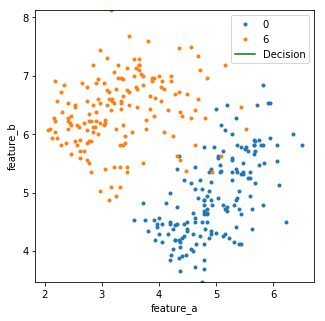

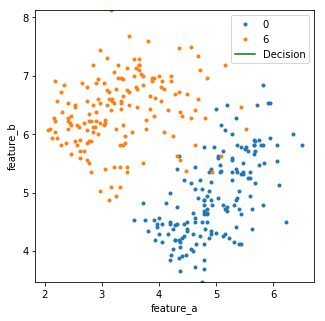

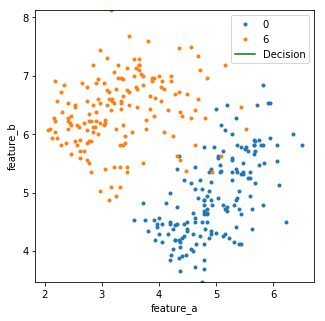

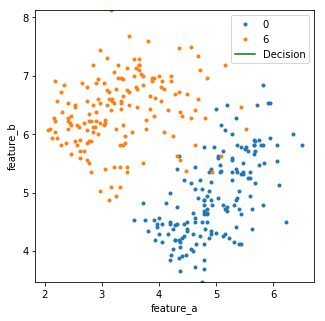

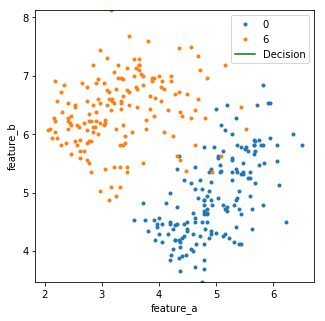

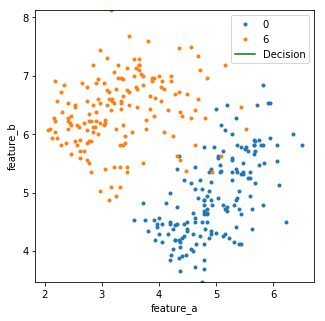

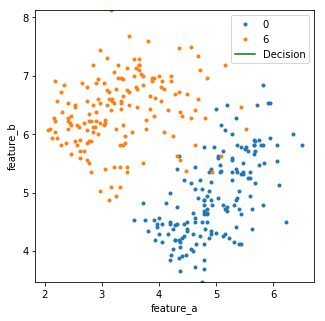

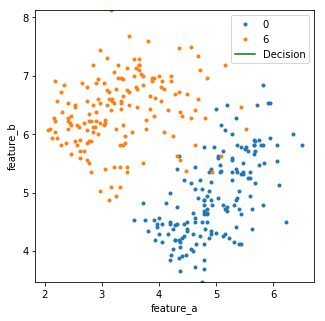

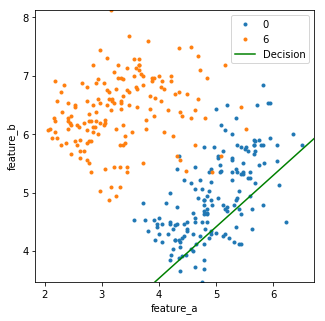

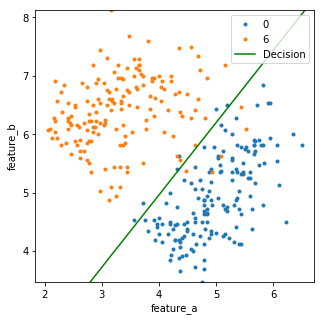

In [20]:
num_iterations = 1000 # set this to the number of iterations
delta = 1e-11 # This may need to be adjusted
step_size = 1e-3
step = 100
for i in range(num_iterations):
    # move x0 some delta and calculate derivative in x0 direction
    # move x1 some delta and calculate derivative in x1 direction
    # update x0 and x1 some step_size in the direction of steepest descent
    grad = get_gradient(w, X_features, logistic_y, delta, logistic_loss)
    w = w + step_size*(-grad)
    if (i+1)%step == 0:
        print("Train Accuracy = {:2f}%".format(accuracy_metrics(X_features, logistic_y, w)))
        print("Test Accuracy = {:2f}%".format(accuracy_metrics(X_features_test, py_test, w)))
        visualize_model(X_features, logistic_y, w)
w

In [21]:
grad

array([ 0.81420051, -0.58058378])

# Part III

Finally, let’s assume that this camera has a special filter in its lens that blurs the MNIST image in a special way before it is detected. Let’s model this 2D blur as a convolution with the 3x3 filter below.

$$X = 
\begin{bmatrix}
    -1 & 0 & 1 \\
    -1 & 0 & 1 \\
    -1 & 0 & 1 \\
\end{bmatrix}$$

Convolve the set of MNIST images with this kernel before proceeding to compute the two features of interest as in Part I: the total image intensity, and the image symmetry. Repeat the exercise above to obtain a plot of classification performance and an average classification accuracy score.

**Note that this classification score (in some sense) reflects what would be possible with a “computational” camera, which has a special aperture shape for enhanced image classification.**

 - Plot Points after feature generation
 - Linear Classification (Pseudo or Gradient method)
   - test/train accuracy
 - Logistic Classification
   - test/train accuracy

In [22]:
from scipy.ndimage.filters import convolve
kernel = [[-1,0,1],[-1,0,1],[-1,0,1]]
X_train_conv = np.zeros(X_train.shape)
X_test_conv = np.zeros(X_test.shape)
for i in range(len(X_train)):
    X_train_conv[i] = convolve(X_train[i,:,:], kernel, mode='constant', cval = 0)
for i in range(len(X_test)):
    X_test_conv[i] = convolve(X_test[i,:,:], kernel, mode='constant', cval = 0)

In [23]:
kernel

[[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]

In [24]:
def compute_features(vector):
    image = vector.reshape(8, 8) # get back original image shape
    def compute_feature_a(image):
        '''compute_feature_a will compute intensity'''
        value = np.mean(image)
        return value

    def compute_feature_b(image):
        '''compute_feature_b will compute symmetry'''
        one_half = np.fliplr(image)
        sym = one_half*image
        sym = np.mean(sym)
        return sym
    
    return compute_feature_a(image), compute_feature_b(image)

Text(0, 0.5, 'feature_b')

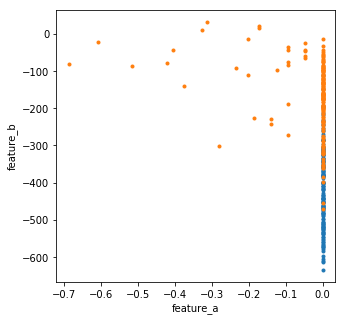

In [25]:
# Apply and plot your features

X_features = np.apply_along_axis(compute_features, 1,
                                 X_train_conv.reshape(X_train_conv.shape[0], X_train_conv.shape[1]*X_train_conv.shape[2]))
X_features_test = np.apply_along_axis(compute_features, 1,
                                 X_test_conv.reshape(X_test_conv.shape[0], X_test_conv.shape[1]*X_test_conv.shape[2]))

X_features_a = X_features[np.where(y_train==number_a)]
X_features_b = X_features[np.where(y_train==number_b)]
plt.figure(figsize=(5,5))
plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.')
plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.')
plt.xlabel('feature_a')
plt.ylabel('feature_b')
#plt.ylim(X_features[:, 1].min(), X_features[:, 1].max()) 

Train Accuracy = 86.377709%
Test Accuracy = 91.666667%


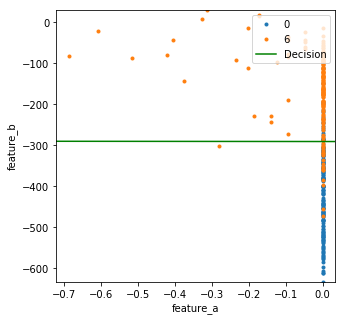

In [26]:
X_features_ones = np.append(X_features, np.ones((X_features.shape[0],1)), axis = 1)
X_features_test_ones = np.append(X_features_test, np.ones((X_features_test.shape[0],1)), axis = 1)

pseudo_y = np.copy(y_train)
pseudo_y[y_train == number_a] = -1
pseudo_y[y_train == number_b] = 1

py_test = np.copy(y_test)
py_test[y_test == number_a] = -1
py_test[y_test == number_b] = 1

# Calculate x below
# ...
X = np.linalg.pinv(X_features_ones)
w = X@pseudo_y

print("Train Accuracy = {:2f}%".format(accuracy_metrics(X_features_ones, pseudo_y,w)))
print("Test Accuracy = {:2f}%".format(accuracy_metrics(X_features_test_ones, py_test, w)))
visualize_model(X_features_ones, pseudo_y, w)

In [27]:
logistic_y = np.copy(y_train)
logistic_y[y_train == number_a] = -1
logistic_y[y_train == number_b] = 1
ly_test = np.copy(y_test)
ly_test[y_test == number_a] = -1
ly_test[y_test == number_b] = 1
w = np.random.rand(2) # init weights to some random value.

Train Accuracy = 50.773994%
Test Accuracy = 50.000000%
Train Accuracy = 50.773994%
Test Accuracy = 50.000000%
Train Accuracy = 50.773994%
Test Accuracy = 50.000000%
Train Accuracy = 50.773994%
Test Accuracy = 50.000000%
Train Accuracy = 50.773994%
Test Accuracy = 50.000000%
Train Accuracy = 50.773994%
Test Accuracy = 50.000000%
Train Accuracy = 50.773994%
Test Accuracy = 50.000000%
Train Accuracy = 50.773994%
Test Accuracy = 50.000000%
Train Accuracy = 50.773994%
Test Accuracy = 50.000000%
Train Accuracy = 50.773994%
Test Accuracy = 50.000000%


array([0.28705561, 0.46758684])

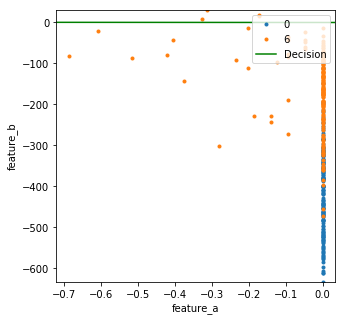

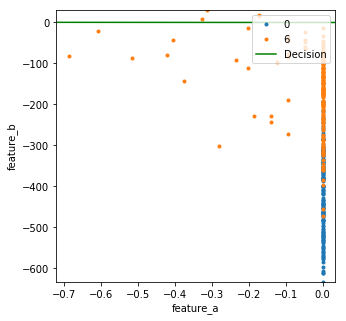

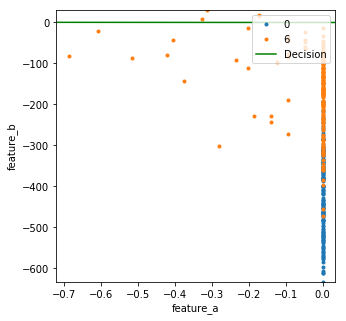

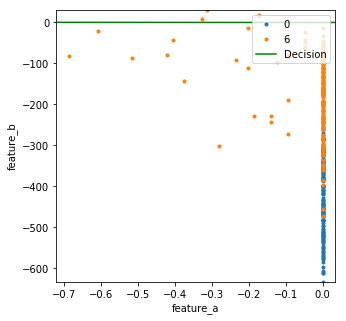

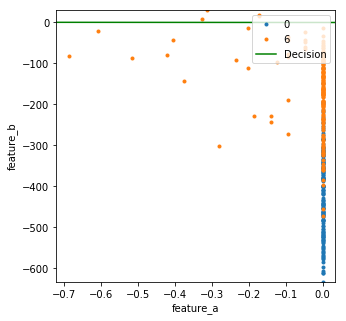

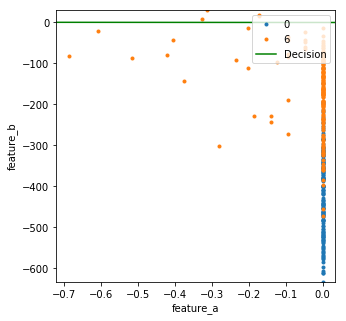

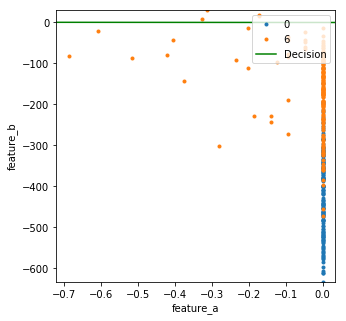

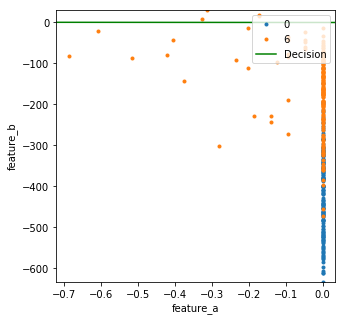

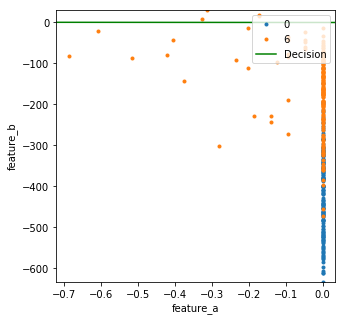

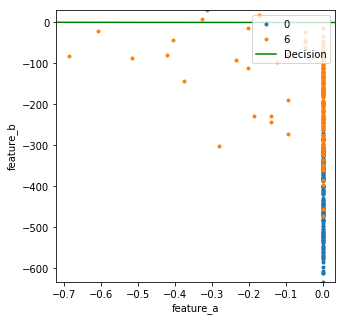

In [28]:
num_iterations = 1000 # set this to the number of iterations
delta = 1e-10 # This may need to be adjusted
step_size = 1e-4
step = 100
for i in range(num_iterations):
    # move x0 some delta and calculate derivative in x0 direction
    # move x1 some delta and calculate derivative in x1 direction
    # update x0 and x1 some step_size in the direction of steepest descent
    grad = get_gradient(w, X_features, logistic_y, delta, logistic_loss)
    w = w + step_size*(-grad)
    if (i+1)%step == 0:
        print("Train Accuracy = {:2f}%".format(accuracy_metrics(X_features, logistic_y, w)))
        print("Test Accuracy = {:2f}%".format(accuracy_metrics(X_features_test, py_test, w)))
        visualize_model(X_features, logistic_y, w)
w

The low accuracy in the final logistic classifier is because we are not using the bias term. If we did, the accuracy would be better here too. 